# Pretrained Big GAN 128 - Scores LB 12
In this kernel, we load Pretrained Big GAN 128 and have fun generating some dog images. 

It's amazing how accurate Big GAN generated dogs appear. Big GAN 128 was trained on the same set of dogs that we are using in Kaggle's Dog Competition. (Stanford Dogs are a subset of ImageNet Dogs). If we were allowed more than 9 hours to train, we could train Big GAN 128 in a Kaggle notebook/kernel and submit it as our competition solution!! Big GAN 128 scores an amazing LB 12!! (Since we need to turn on internet to download pretrained network weights, the outputted images from this notebook/kernel cannot be submitted).

Big GAN 128 can produce 1000 different classes of images. A full list is [here][4]. For example class 472 is a `canoe` and class 71 is a `scorpion`. Try changing the code below to see images besides dogs. Furthermore you can do latent walks between different classes. As an example I morph dogs into cats below. Dogs are classes 151 thru 280 and cats are 281 thru 293.

You can read a blog about Big GAN [here][1]. A paper descibing Big GAN is [here][3]. We download Big GAN from GitHub [here][2]

[1]: https://medium.com/syncedreview/biggan-a-new-state-of-the-art-in-image-synthesis-cf2ec5694024
[2]: https://github.com/huggingface/pytorch-pretrained-BigGAN
[3]: https://openreview.net/forum?id=B1xsqj09Fm
[4]: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

# Load Pretrained Big GAN 128

In [2]:
! pip install pytorch-pretrained-biggan

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np, pandas as pd, os
import os, torch, gc
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_pretrained_biggan import BigGAN, truncated_noise_sample

# LOAD PRETRAINED BIGGAN-DEEP-128
model = BigGAN.from_pretrained('biggan-deep-256')

100%|██████████| 715/715 [00:00<00:00, 200852.41B/s]


# Fun Latent Walk
Below are latent walks from dogs to cats. Big GAN recognizes 1000 different category classes. There is a complete list of classes [here][1]. For example, `Labrador retriever` is class 208 and `Tiger` is class 292. By changing the `start class` and `end class` for `class_vector` below you can control what you would like to see morph into what. 

The smooth transistions of the latent walks below demonstrate that Big GAN 128 is not a memorizer GAN.

[1]: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [4]:
COLS = 10
ROWS = 10
truncation = 0.5
class_vector = np.zeros((ROWS*COLS,1000),dtype=np.float32)
noise_vector = np.zeros((ROWS*COLS,128),dtype=np.float32)

for j in range(ROWS):
    
    # CHANGE THE FOLLOWING TWO LINES TO CONTROL WHAT CLASS MORPHS TO WHAT CLASS
    #################
    # DOGS ARE CLASSES 151 THRU 281, CATS ARE 281 THRU 294
    # CATEGORY LIST HERE: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
    class_vector[j*COLS,np.random.randint(151,281)]=1 # START CLASS
    class_vector[(j+1)*COLS-1,np.random.randint(281,294)]=1 # END CLASS   
    #################
    
    step = class_vector[(j+1)*COLS-1,] - class_vector[j*COLS,]
    for k in range(1,COLS-1):
        class_vector[j*COLS+k,] = class_vector[j*COLS,] + (k/(COLS-1))*step
    noise_vector[j*COLS,:] = truncated_noise_sample(truncation=truncation, batch_size=1)
    noise_vector[(j+1)*COLS-1,:] = truncated_noise_sample(truncation=truncation, batch_size=1)
    step = noise_vector[(j+1)*COLS-1,]-noise_vector[j*COLS,]
    for k in range(1,COLS-1):
        noise_vector[j*COLS+k,] = noise_vector[j*COLS,] + (k/(COLS-1))*step

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
model.to('cuda')

# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')
output = output.numpy().transpose(0, 2, 3, 1)

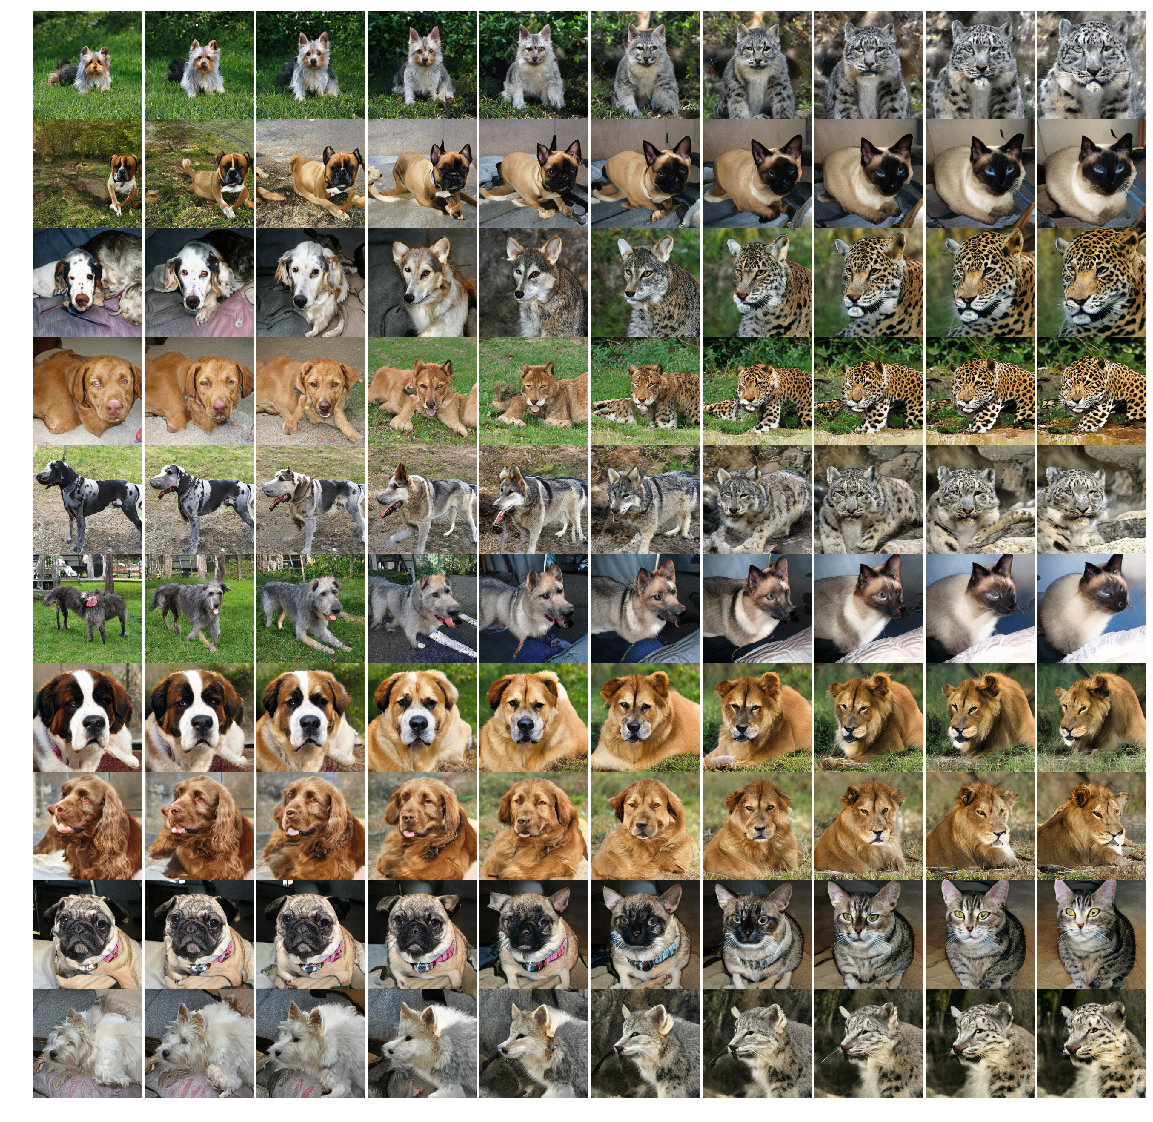

In [5]:
# DISPLAY LATENT WALK
plt.figure(figsize=(int(2*COLS),int(2*ROWS)))
plt.subplots_adjust(hspace=0,wspace=0)
for k in range(ROWS*COLS):
    plt.subplot(ROWS,COLS,k+1)
    img = Image.fromarray( ((output[k,]+1.)/2.*255).astype('uint8') )
    plt.axis('off')
    plt.imshow(img)
plt.show(img)

# Generate 10000 Dog Images
If we set the variable `truncation` below to `0.5` then the dog images will look photo realistic but they will also have less variation in the background and pose. The competition metric rewards variation more than quality. Therefore `truncation=0.5` yields LB 34, whereas `trucation=1.0` yields LB 12 even though the latter are less photo realistic. (In the latent walks above, we used `truncation=0.5` and you can see the image quality difference).

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv('/kaggle/input/dogs-index/dogs.csv')

In [9]:
int(df['Number'][0][1:4])

151

In [10]:
print(len(df))

120


In [11]:
os.mkdir('../tmp')
os.mkdir('../tmp/images/')

In [12]:
from tqdm.auto import tqdm

In [11]:
# GENERATE SAMPLES
# TRUNCATION VARIABLE AFFECTS QUALITY AND DIVERSITY
truncation=0.5
for i in tqdm(range(120)):
    folder = df["Folder"][i]
    index = int(df['Number'][i][1:4])
    os.mkdir('../tmp/images/'+folder)
    for k in range(1):
        SAMPLES = 30
        class_vector = np.zeros((SAMPLES,1000),dtype=np.float32)
        for x in range(SAMPLES): 
            class_vector[x,np.random.randint(index,index+1)]=1 #(281,294) are cats
        # CATEGORY LIST HERE: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
        noise_vector = truncated_noise_sample(truncation=truncation, batch_size=SAMPLES)

        # All in tensors
        noise_vector = torch.from_numpy(noise_vector)
        class_vector = torch.from_numpy(class_vector)

        # If you have a GPU, put everything on cuda
        noise_vector = noise_vector.to('cuda')
        class_vector = class_vector.to('cuda')
        model.to('cuda')

        # Generate an image
        with torch.no_grad():
            output = model(noise_vector, class_vector, truncation)

        # If you have a GPU put back on CPU
        output = output.to('cpu')
        output = output.numpy().transpose(0, 2, 3, 1)

        for j in range(30):
            img = Image.fromarray( ((output[j,]+1.)/2.*255).astype('uint8') )
            img = img.resize((224,224), Image.ANTIALIAS)
            img.save('../tmp/images/'+folder+"/"+str(k*30+j)+'.jpg')
    #if k%10==0: print(k)

In [13]:
# GENERATE SAMPLES
# TRUNCATION VARIABLE AFFECTS QUALITY AND DIVERSITY


In [13]:
os.listdir('../tmp')

['images']

In [12]:
import shutil 
import os.path

# Creating the ZIP file 
archived = shutil.make_archive('/kaggle/working/GAN', 'zip', '../tmp')

In [13]:
os.listdir('../tmp')

['images']

In [14]:
shutil.copyfile(r'../tmp/zip_file.zip', r'/kaggle/working/GAN.zip')

FileNotFoundError: [Errno 2] No such file or directory: '../tmp/zip_file.zip'

In [1]:
from IPython.display import FileLink

FileLink(r'/kaggle/working/GAN.zip')

/kaggle/working/GAN.zip

<a href=""> Download File </a>

# Display Examples

In [26]:
truncation=0.5
for i in tqdm(range(1)):
    folder = df["Folder"][i]
    index = int(df['Number'][i][1:4])
    for k in range(1):
        SAMPLES = 30
        class_vector = np.zeros((SAMPLES,1000),dtype=np.float32)
        for x in range(SAMPLES): 
            class_vector[x,np.random.randint(162,163)]=1 #(281,294) are cats
        # CATEGORY LIST HERE: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
        noise_vector = truncated_noise_sample(truncation=truncation, batch_size=SAMPLES)

        # All in tensors
        noise_vector = torch.from_numpy(noise_vector)
        class_vector = torch.from_numpy(class_vector)

        # If you have a GPU, put everything on cuda
        noise_vector = noise_vector.to('cuda')
        class_vector = class_vector.to('cuda')
        model.to('cuda')

        # Generate an image
        with torch.no_grad():
            output = model(noise_vector, class_vector, truncation)

        # If you have a GPU put back on CPU
        output = output.to('cpu')
        output = output.numpy().transpose(0, 2, 3, 1)

        for j in range(30):
            img = Image.fromarray( ((output[j,]+1.)/2.*255).astype('uint8') )
            img = img.resize((224,224), Image.ANTIALIAS)
            img.save('../tmp/images/'+folder+"/"+str(k*30+j)+'.jpg')
    #if k%10==0: print(k)

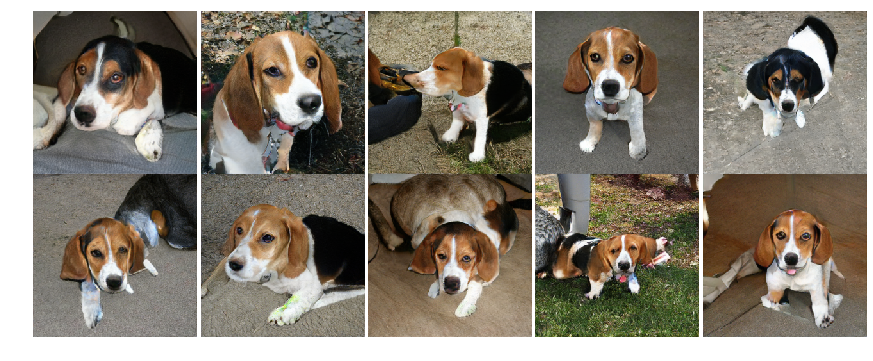

In [27]:
# DISPLAY GENERATED DOGS
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0,wspace=0)
for k in range(10):
    plt.subplot(5,5,k+1)
    img = Image.fromarray( ((output[k,]+1.)/2.*255).astype('uint8') )
    plt.axis('off')
    plt.imshow(img)
plt.show(img)

# Calculate LB Score

In [ ]:
# CLEAR GPU MEMORY
del model, output, class_vector, noise_vector, img; gc.collect()
torch.cuda.empty_cache()

In [ ]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2

In [ ]:
# COMPUTE LB SCORE
mm = []; ss =[]; ff = []
user_images_unzipped_path = '../tmp/images/'
images_path = [user_images_unzipped_path,'../input/generative-dog-images/all-dogs/all-dogs/']
public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

fid_epsilon = 10e-15

fid_value_public, distance_public, mm, ss, ff = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=mm, ss=ss, ff=ff)
distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
          fid_value_public /(distance_public + fid_epsilon))